In [ ]:
# Importing libraries

%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

In [2]:
# Fetch MNIST dataset from Yann LeCun's website

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

(60000, 28, 28) (10000, 28, 28)
5


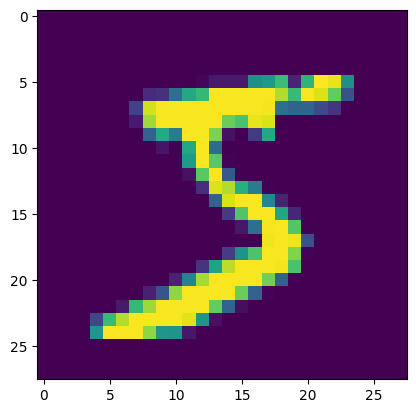

In [53]:
print(X_train.shape, X_test.shape)
imshow(X_train[0])
print(Y_train[0])

In [55]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [ ]:
def logsumexp(x):
  c = x.max(axis=1)
  return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
  # initialize weights
  out = np.zeros((len(y),10), np.float32)
  out[range(out.shape[0]),y] = 1

  # forward
  x_l1 = x.dot(l1)
  x_relu = np.maximum(x_l1, 0)
  x_l2 = x_relu.dot(l2)
  x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
  x_loss = (-out * x_lsm).mean(axis=1)




  # backward
  d_out = -out / len(y)

  # derivative of logsoftmax
  dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

  # derivative of layer 2
  d_l2 = x_relu.T.dot(dx_lsm)
  dx_relu = dx_lsm.dot(l2.T)

  # derivative of relu
  dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

  # derivative of layer 1
  d_l1 = x.T.dot(dx_l1)

  return x_loss, x_l2, d_l1, d_l2


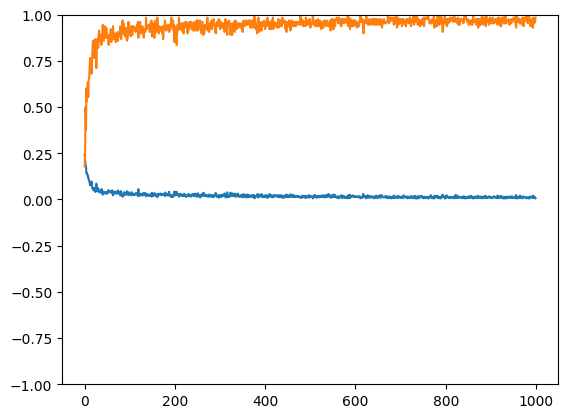

In [51]:
# numpy training
def layer_init(m, h):

  ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
  return ret.astype(np.float32)

# init
np.random.seed(1337)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
for i in range(1000):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = X_train[samp].reshape((-1, 28*28))
  Y = Y_train[samp]
  x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)

  cat = np.argmax(x_l2, axis=1)
  accuracy = (cat == Y).mean()

  # SGD
  l1 = l1 - lr*d_l1
  l2 = l2 - lr*d_l2

  loss = x_loss.mean()
  losses.append(loss)
  accuracies.append(accuracy)

plt.ylim(-1, 1)
plot(losses)
plot(accuracies)

In [52]:
# testing
def forward(x):
  x = x.dot(l1)
  x = np.maximum(x, 0)
  x = x.dot(l2)
  return x

def numpy_eval():
  Y_test_predictions_out = forward(X_test.reshape((-1, 28*28)))
  Y_test_predictions = np.argmax(Y_test_predictions_out, axis=1)
  return (Y_test == Y_test_predictions).mean()

numpy_eval()

0.9639